# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE")

Wall time: 0 ns


# Overview

In the following notebook we compute the FTLE on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. FTLE:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid.
    <br />
    
    * Compute FTLE from maximum singular value $ \sigma_{max} $ of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ according to:
    \begin{equation}
    \mathrm{FTLE}_{t_0}^{t_N} = \dfrac{1}{t_N-t_0}\log(\sigma_{max})
    \end{equation}

# Import Data

In [2]:
%%time
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 156 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
%%time
import numpy as np

# Number of cores for parallel computing
Ncores = 4

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# Periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

Wall time: 997 µs


# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# Time step-size (in days)
dt = .1

# NOTE: For computing the backward FTLE field tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # len(time) = N

# Length of time interval (in days)
lenT = abs(tN-t0)

# Longitudinal and latitudinal boundaries (in degrees)
xmin = -3.5
xmax = 1
ymin = -32
ymax = -24

# Make sure that the chosen domain is part of the data domain
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# Spacing of meshgrid (in degrees)
dx = 0.015
dy = 0.015

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Wall time: 998 µs


# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default is "cubic".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

Wall time: 197 ms


# FTLE

Next, we compute the FTLE over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. From the maximum singular value of the gradient of the flow map we can then compute the FTLE.

In [6]:
%%time
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to integrate trajectories (=flow map)
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/100, 1/5]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

def parallel_FTLE(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])

    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # shape (N, Nx*Ny, 2, 2)

    # Extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # shape (N, 2, 2, Nx*Ny)

    # Compute FTLE
    FTLE = []
    for i in range(gradFmap_t0_tN.shape[2]):
        FTLE.append(_FTLE(gradFmap_t0_tN[:,:,i], lenT))
    
    return FTLE

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_FTLE)(x0_batch[i], y0_batch[i]) for i in tqdm(range(len(x0_batch))))

# Extract FTLE from results of parallel computing
FTLE = results[0]

for res in results[1:]:
    FTLE = np.append(FTLE, res)
    
# Reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1]))
FTLE = FTLE.reshape((X_domain.shape[0], X_domain.shape[1]))

  0%|          | 0/4 [00:00<?, ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.2min remaining:  2.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.2min finished
Wall time: 2min 14s


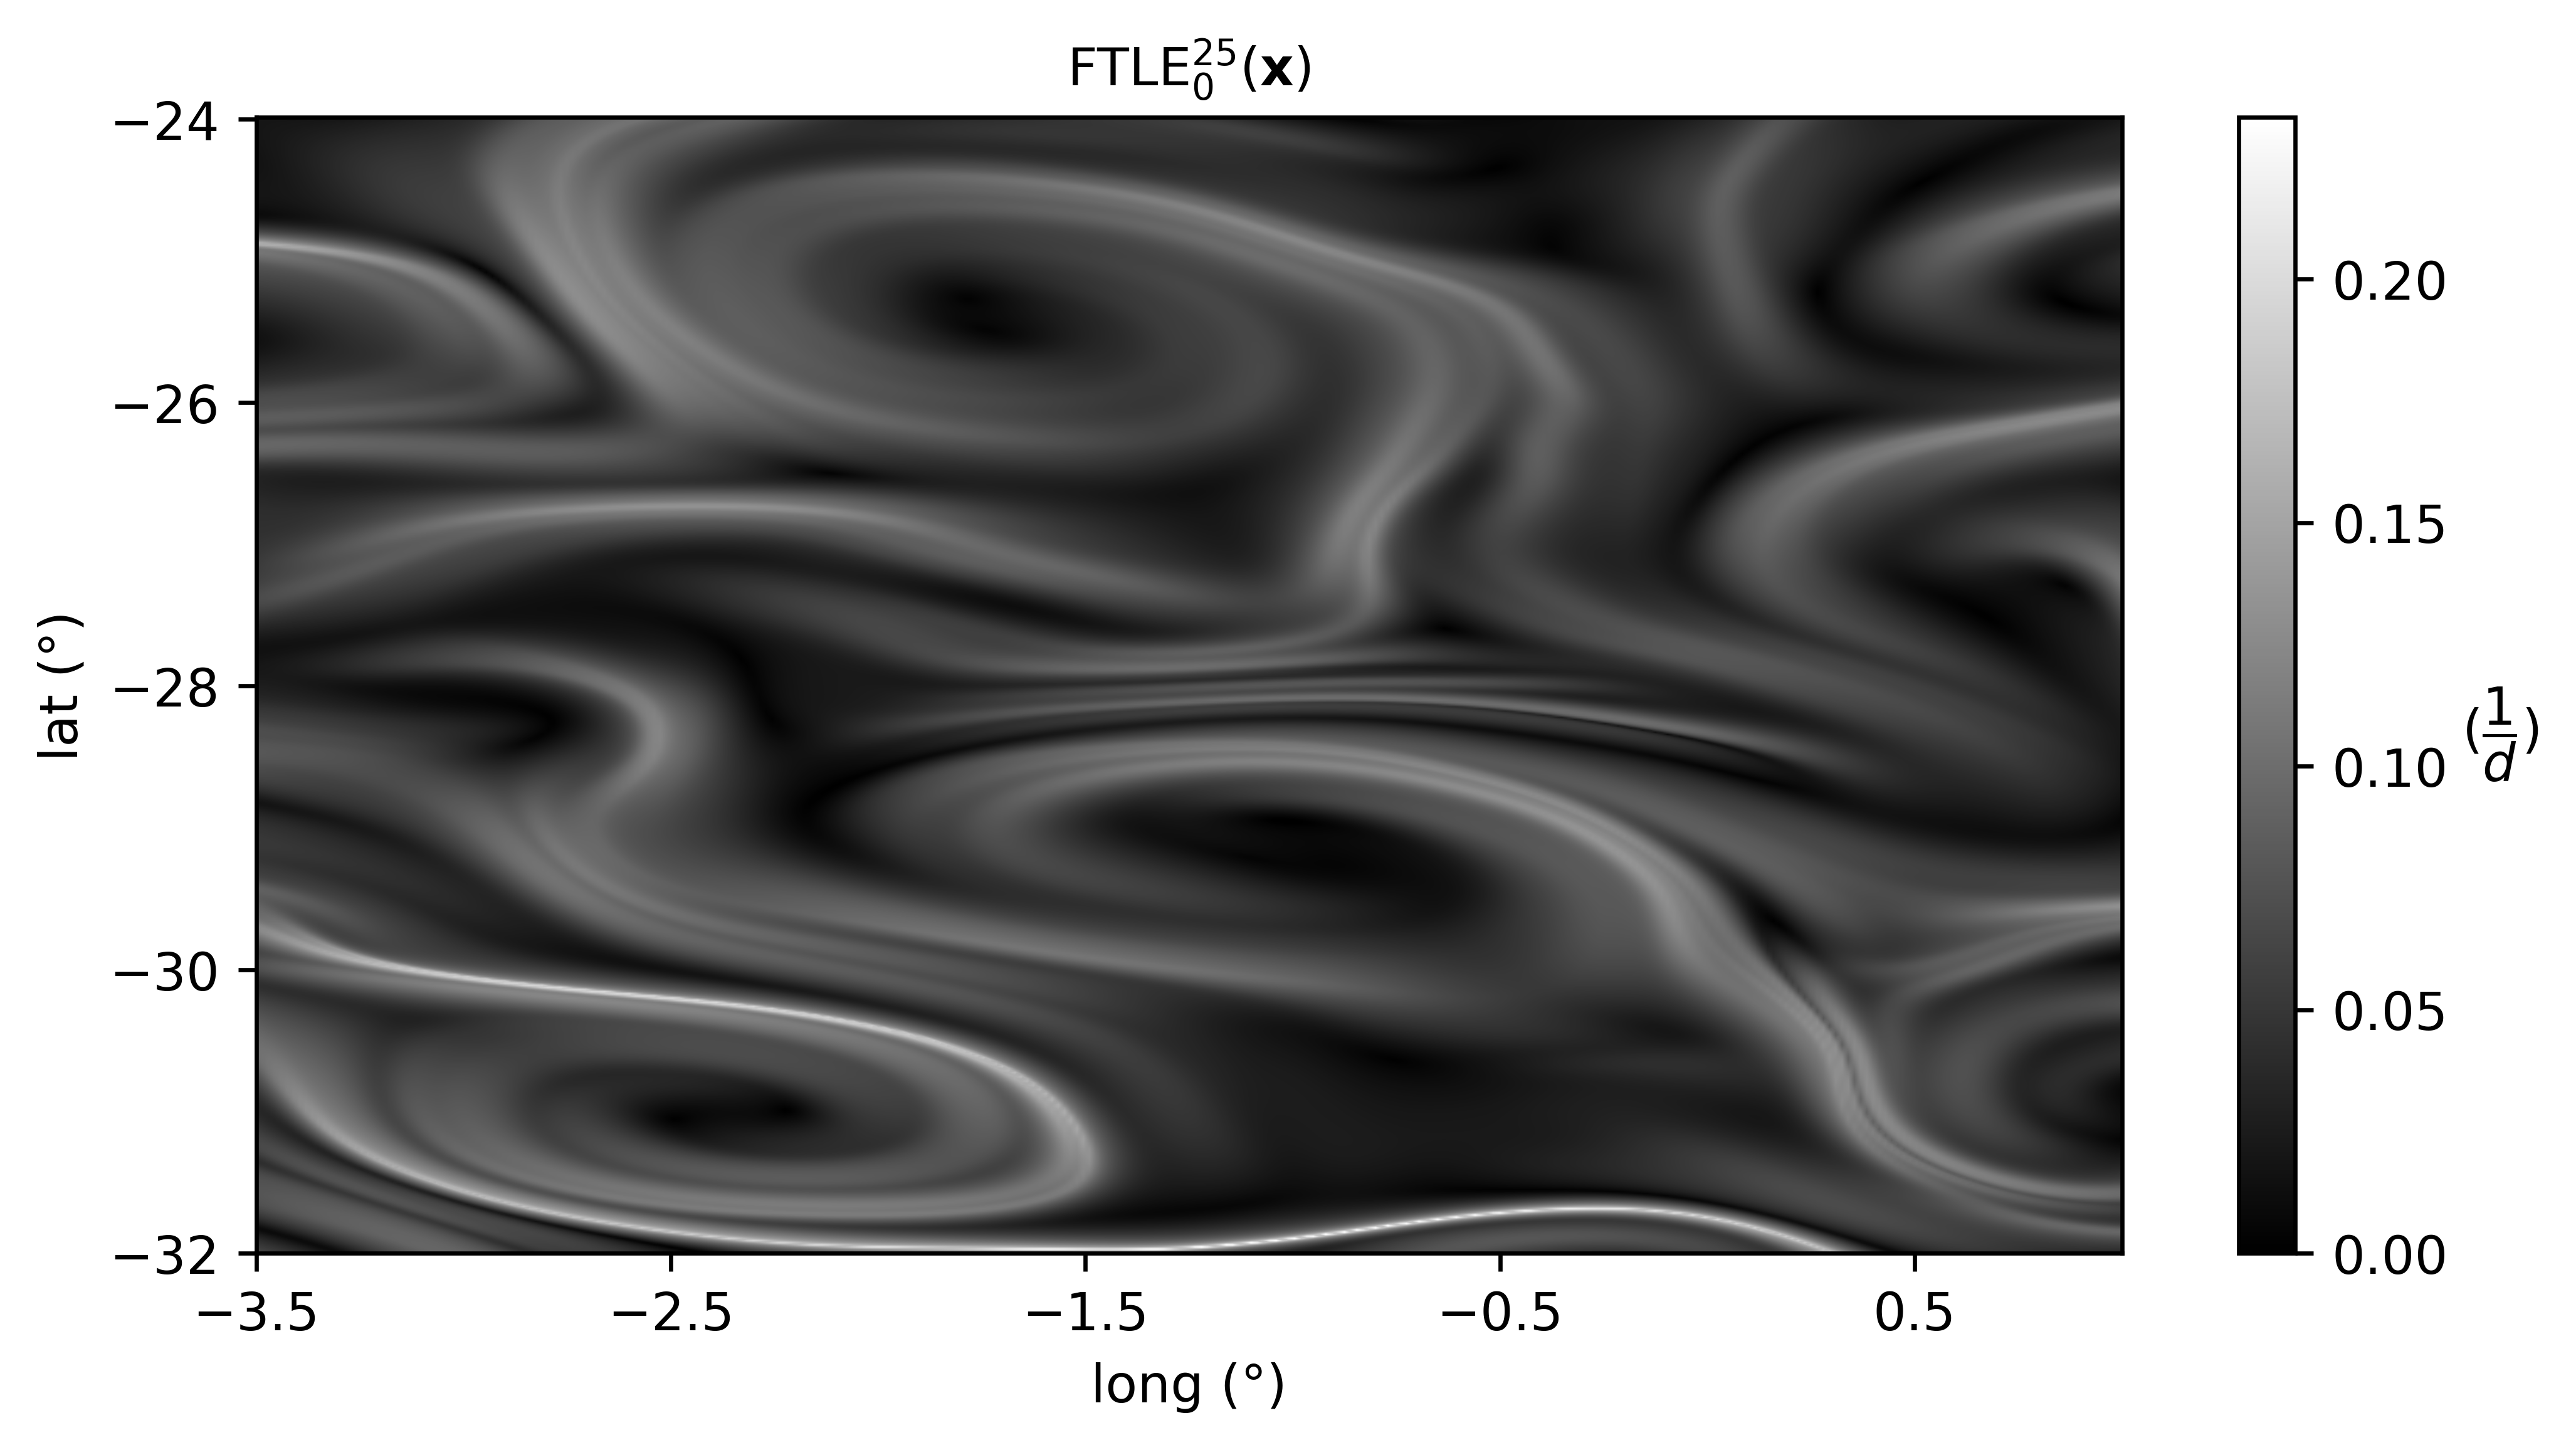

In [7]:
######################## PLOT RESULTS ########################
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of FTLE over meshgrid of initial conditions
cax = ax.contourf(X0_gridded, Y0_gridded, np.ma.masked_invalid(FTLE), cmap = "gist_gray", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+0.1, 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+0.1, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))
cbar.ax.set_ylabel(r'$(\dfrac{1}{d})$', rotation = 0, labelpad = 10, fontsize = 10)

# Title
ax.set_title(r'$ \mathrm{FTLE}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$'+r'$(\mathbf{x})$', fontsize = 10)

plt.show()

The forward FTLE field is plotted with respect to the initial position of the particles. Repelling LCS are visible as ridges in the forward FTLE field, whereas trenches of FTLE field signal parabolic (jet-type) LCSs. An analogous statement holds for attracting LCS and the backward FTLE field. As a first approach, ridges of the FTLE field can be extracted using simple thresholding. This should already provide a good hint to the location of hyperbolic features.

TLE ridges, however, are necessary but not sufficient conditions for hyperbolic LCS. Ridges of the FTLE field have also been related to regions of high shear. As a consequence the FTLE should only be considered as a first (and relatively rapid) approach for finding hyperbolic (repelling/attracting) LCS. More advanced methods such as the computation of the tensorlines associated to the eigenvalues of the Cauchy-Green strain tensor, should be used for a precise computation of hyperbolic LCS (see [HyperbolicLCS](http://localhost:8889/notebooks/TBarrier/2D/demos/AdvectiveBarriers/HyperbolicLCS/Main/HyperbolicLCSAgulhas.ipynb)).[1, 2].

# References

[1] Haller, G. (2015). Lagrangian coherent structures. Annual Review of Fluid Mechanics, 47, 137-162.

[2] Haller, G., & Sapsis, T. (2011). Lagrangian coherent structures and the smallest finite-time Lyapunov exponent. Chaos: An Interdisciplinary Journal of Nonlinear Science, 21(2), 023115.